# Comprehensive EDA: 2 Years Historical Data
Extract, Clean, Analyze AQI and Weather Data

## 1. Import Required Libraries

In [47]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
sys.path.append(os.path.join(os.getcwd(), '..'))

## 2. Load & Fetch Historical Data (2 Years)

In [48]:
from dotenv import load_dotenv
load_dotenv()
LATITUDE = float(os.getenv('LATITUDE', 25.3792))
LONGITUDE = float(os.getenv('LONGITUDE', 68.3683))
TIMEZONE = os.getenv('TIMEZONE', 'Asia/Karachi')

In [49]:
from src.backend.api_client import fetch_historical_weather, fetch_historical_aqi

In [50]:
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")
start_date = (datetime.now() - timedelta(days=730)).strftime("%Y-%m-%d")
weather_df = fetch_historical_weather(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
aqi_df = fetch_historical_aqi(start_date=start_date, end_date=end_date, latitude=LATITUDE, longitude=LONGITUDE, timezone=TIMEZONE)
df = pd.merge(weather_df, aqi_df, on='time', how='inner')
if 'us_aqi' in df.columns:
    df = df.rename(columns={'us_aqi': 'aqi'})
print(f"Dataset: {len(df)} records, {len(df.columns)} features\nDate range: {df['time'].min()} to {df['time'].max()}")
df.head(3)

Dataset: 17520 records, 14 features
Date range: 2024-02-16 19:00:00+00:00 to 2026-02-15 18:00:00+00:00


,time,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_monoxide,aqi
0,2024-02-16 19:00:00+00:00,15.55,60.556461,1017.200012,9.693296,328.671356,0.0,50.200001,32.500000,29.9,6.1,47.0,652.0,97.969856
1,2024-02-16 20:00:00+00:00,15.40,60.314972,1016.799988,8.287822,325.619598,0.0,47.500000,30.700001,26.4,5.8,49.0,610.0,97.030144
2,2024-02-16 21:00:00+00:00,14.25,65.619553,1016.299988,9.659814,333.435028,0.0,45.299999,29.299999,23.0,5.4,50.0,566.0,96.028374


## 3. Data Cleaning & Preprocessing

In [51]:
def handle_missing_values(df):
    df_clean = df.copy()
    weather_vars = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m']
    for var in weather_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=3).interpolate(method='linear')
    if 'precipitation' in df_clean.columns:
        df_clean['precipitation'] = df_clean['precipitation'].fillna(0)
    if 'wind_direction_10m' in df_clean.columns:
        df_clean['wind_direction_10m'] = df_clean['wind_direction_10m'].fillna(method='ffill', limit=3).interpolate(method='linear')
    pollutant_vars = ['pm10', 'pm2_5', 'nitrogen_dioxide', 'sulphur_dioxide', 'ozone', 'carbon_monoxide', 'aqi']
    for var in pollutant_vars:
        if var in df_clean.columns:
            df_clean[var] = df_clean[var].fillna(method='ffill', limit=2)
            df_clean[var] = df_clean[var].fillna(df_clean[var].rolling(window=12, min_periods=1, center=True).median())
    return df_clean

df_clean = handle_missing_values(df)
print(f"Missing values after cleaning: {df_clean.isnull().sum().sum()}")

Missing values after cleaning: 0


In [52]:
def detect_duplicate_weather(df, threshold=0.01):
    df_dup = df.copy()
    weather_features = ['temperature_2m', 'relative_humidity_2m', 'pressure_msl', 'wind_speed_10m', 'wind_direction_10m', 'precipitation']
    is_duplicate = pd.Series(False, index=df_dup.index)
    for i in range(1, len(df_dup)):
        diffs = [abs(df_dup[f].iloc[i] - df_dup[f].iloc[i-1]) / (df_dup[f].max() - df_dup[f].min()) for f in weather_features if f in df_dup.columns and df_dup[f].max() - df_dup[f].min() > 0]
        if len(diffs) > 0 and all(d < threshold for d in diffs):
            is_duplicate.iloc[i] = True
    df_dup['is_duplicate'] = is_duplicate
    return df_dup

df_clean = detect_duplicate_weather(df_clean)
print(f"Duplicate weather patterns: {df_clean['is_duplicate'].sum()}")

Duplicate weather patterns: 204


In [53]:
def validate_data(df):
    checks = [('AQI', df['aqi'].min(), df['aqi'].max(), '0-600') if 'aqi' in df.columns else None,
              ('Temperature', df['temperature_2m'].min(), df['temperature_2m'].max(), '-40 to 60°C') if 'temperature_2m' in df.columns else None,
              ('Humidity', df['relative_humidity_2m'].min(), df['relative_humidity_2m'].max(), '0-100%') if 'relative_humidity_2m' in df.columns else None]
    return [c for c in checks if c]

for var, min_val, max_val, expected in validate_data(df_clean):
    print(f"{var}: {min_val:.1f} - {max_val:.1f} (expected: {expected})")

AQI: 33.7 - 167.0 (expected: 0-600)
Temperature: 7.3 - 49.0 (expected: -40 to 60°C)
Humidity: 3.3 - 99.7 (expected: 0-100%)


In [54]:
os.makedirs('../data', exist_ok=True)
df_clean.to_csv('../data/eda_cleaned_data_2years.csv', index=False)
print(f"Cleaned data saved: {len(df_clean)} records, {len(df_clean.columns)} features")

Cleaned data saved: 17520 records, 15 features


## 4. Data Quality Overview

In [55]:
df_clean.describe()

,temperature_2m,relative_humidity_2m,pressure_msl,wind_speed_10m,wind_direction_10m,precipitation,pm10,pm2_5,nitrogen_dioxide,sulphur_dioxide,ozone,carbon_monoxide,aqi
count,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000,17520.000000
mean,27.643843,52.496883,1007.756287,12.816378,194.043259,0.028019,56.053925,27.517899,8.814527,7.168048,80.552109,467.929047,84.982826
std,7.405766,22.562105,7.584996,6.729530,101.241554,0.367569,34.095337,14.728827,8.117609,3.265111,34.133465,419.971283,26.373035
min,7.300000,3.310669,989.400024,0.000000,0.690264,0.000000,4.300000,3.800000,0.000000,0.800000,12.000000,97.000000,33.715275
25%,23.100000,34.328984,1001.599976,7.742093,163.707382,0.000000,34.700001,17.400000,3.100000,5.000000,53.000000,196.000000,65.984045
50%,28.250000,52.284693,1007.900024,12.007498,223.939178,0.000000,48.000000,23.600000,6.300000,6.700000,73.000000,300.000000,78.670208
75%,32.700001,71.535963,1014.200012,17.418196,243.487671,0.000000,68.000000,33.799999,11.300000,8.800000,107.000000,599.000000,97.321419
max,49.049999,99.697578,1025.800049,43.976028,360.000000,12.800000,415.399994,105.500000,57.599998,29.900000,182.000000,4083.000000,166.951767


In [56]:
df_clean.dtypes

time                    datetime64[ns, UTC]
temperature_2m                      float32
relative_humidity_2m                float32
pressure_msl                        float32
wind_speed_10m                      float32
wind_direction_10m                  float32
precipitation                       float32
pm10                                float32
pm2_5                               float32
nitrogen_dioxide                    float32
sulphur_dioxide                     float32
ozone                               float32
carbon_monoxide                     float32
aqi                                 float32
is_duplicate                           bool
dtype: object

## 5. Target Variable (AQI) Deep Dive

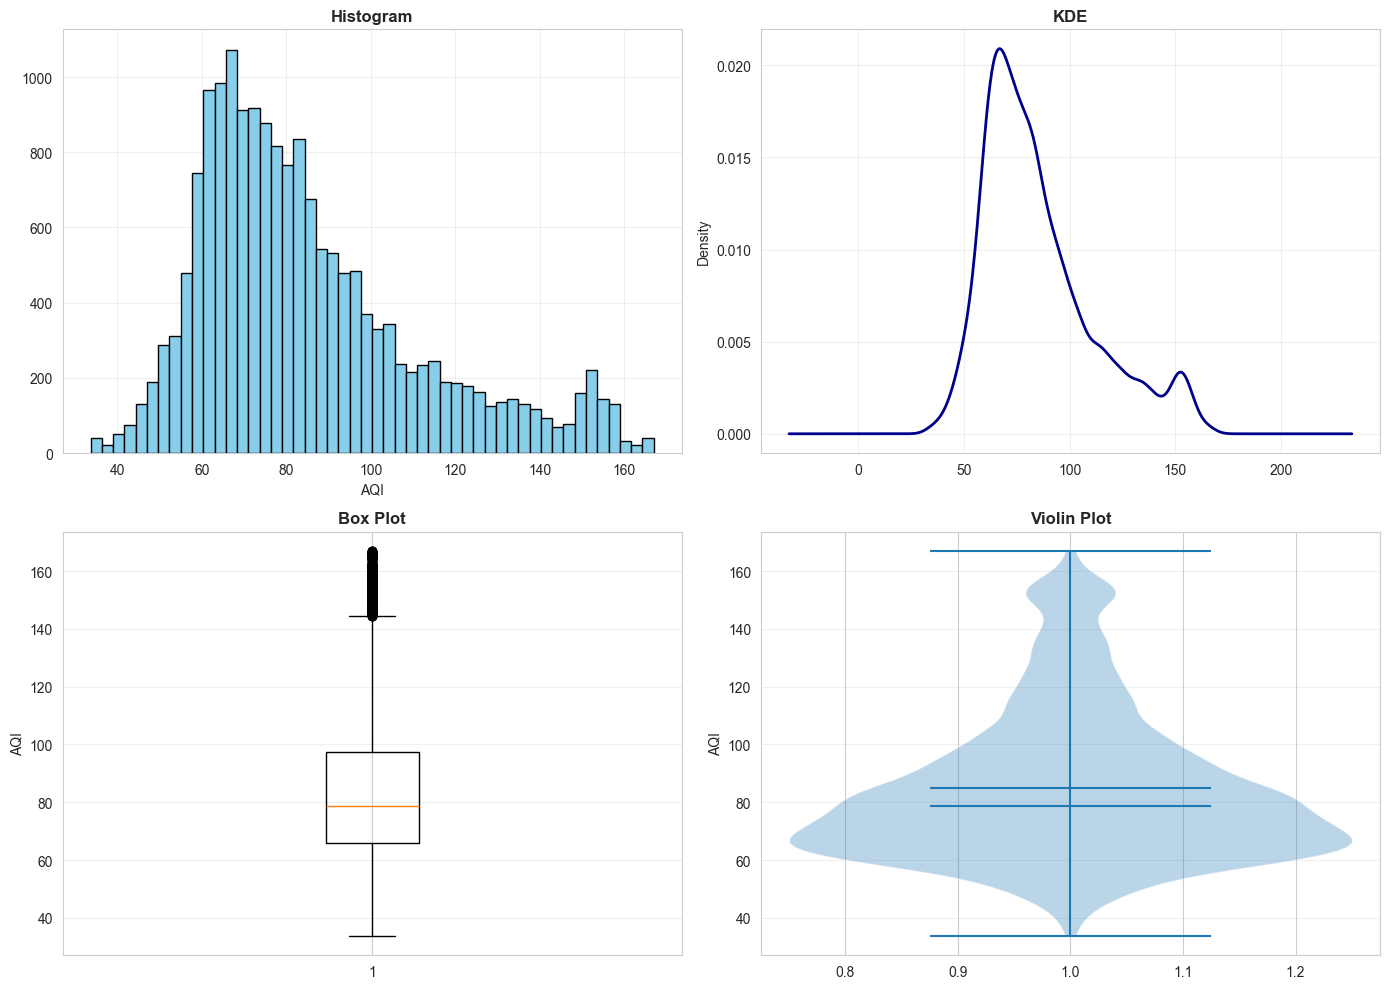

Mean: 84.98, Median: 78.67, Std: 26.37


In [57]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0, 0].hist(df_clean['aqi'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram', fontweight='bold')
axes[0, 0].set_xlabel('AQI')
axes[0, 0].grid(True, alpha=0.3)

df_clean['aqi'].plot(kind='kde', ax=axes[0, 1], color='darkblue', linewidth=2)
axes[0, 1].set_title('KDE', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot(df_clean['aqi'], vert=True)
axes[1, 0].set_title('Box Plot', fontweight='bold')
axes[1, 0].set_ylabel('AQI')
axes[1, 0].grid(True, alpha=0.3, axis='y')

axes[1, 1].violinplot([df_clean['aqi']], vert=True, showmeans=True, showmedians=True)
axes[1, 1].set_title('Violin Plot', fontweight='bold')
axes[1, 1].set_ylabel('AQI')
axes[1, 1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Mean: {df_clean['aqi'].mean():.2f}, Median: {df_clean['aqi'].median():.2f}, Std: {df_clean['aqi'].std():.2f}")

aqi_category
Moderate                   12996
Unhealthy for Sensitive     3302
Unhealthy                    698
Good                         524
Name: count, dtype: int64


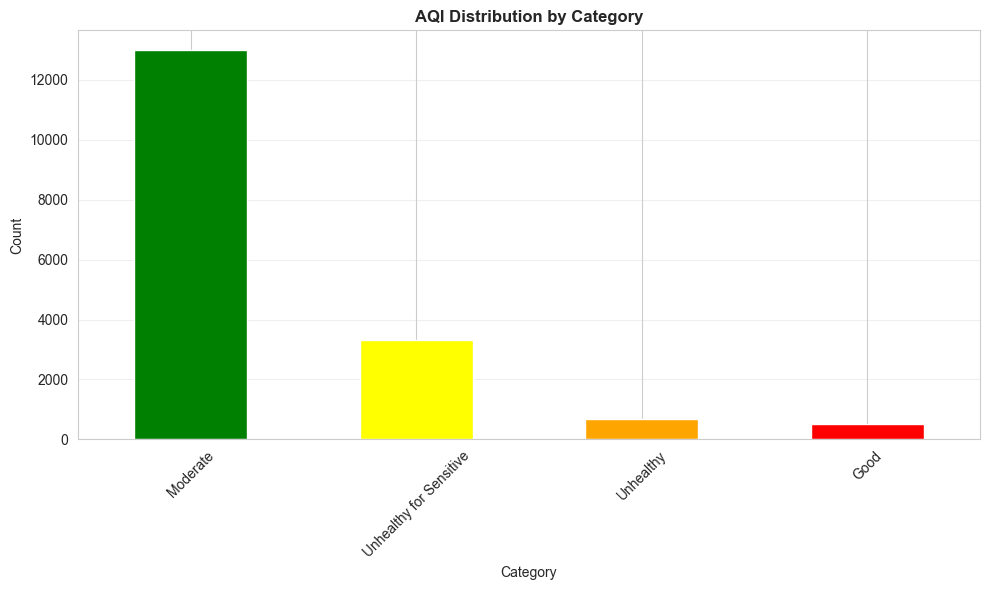

In [58]:
def categorize_aqi(aqi):
    if aqi <= 50: return 'Good'
    elif aqi <= 100: return 'Moderate'
    elif aqi <= 150: return 'Unhealthy for Sensitive'
    elif aqi <= 200: return 'Unhealthy'
    elif aqi <= 300: return 'Very Unhealthy'
    else: return 'Hazardous'

df_clean['aqi_category'] = df_clean['aqi'].apply(categorize_aqi)
category_counts = df_clean['aqi_category'].value_counts()
print(category_counts)

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green', 'yellow', 'orange', 'red', 'purple', 'maroon']
category_counts.plot(kind='bar', ax=ax, color=colors[:len(category_counts)])
plt.title('AQI Distribution by Category', fontweight='bold')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 6. Temporal Patterns Analysis

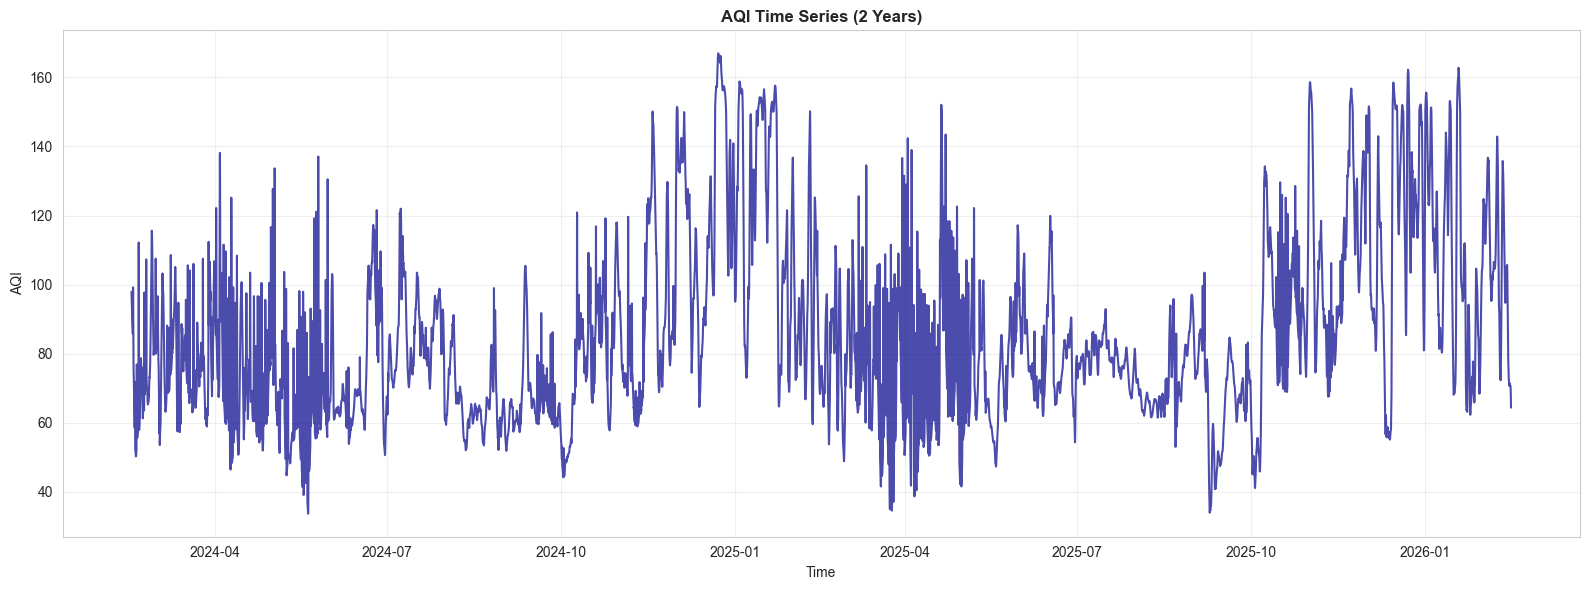

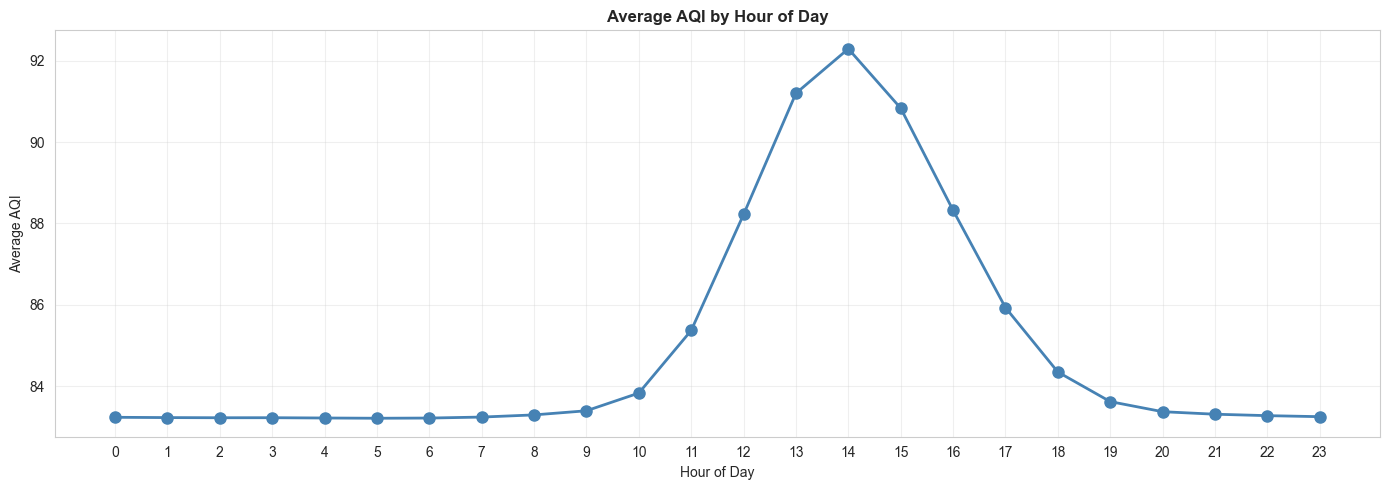

In [59]:
df_clean['time'] = pd.to_datetime(df_clean['time'])

plt.figure(figsize=(16, 6))
plt.plot(df_clean['time'], df_clean['aqi'], linewidth=1.5, color='darkblue', alpha=0.7)
plt.title('AQI Time Series (2 Years)', fontweight='bold')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

df_clean['hour'] = df_clean['time'].dt.hour
df_clean['day_of_week'] = df_clean['time'].dt.dayofweek
df_clean['month'] = df_clean['time'].dt.month
df_clean['day'] = df_clean['time'].dt.day

hourly_avg = df_clean.groupby('hour')['aqi'].mean()
plt.figure(figsize=(14, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=8, color='steelblue')
plt.title('Average AQI by Hour of Day', fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average AQI')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

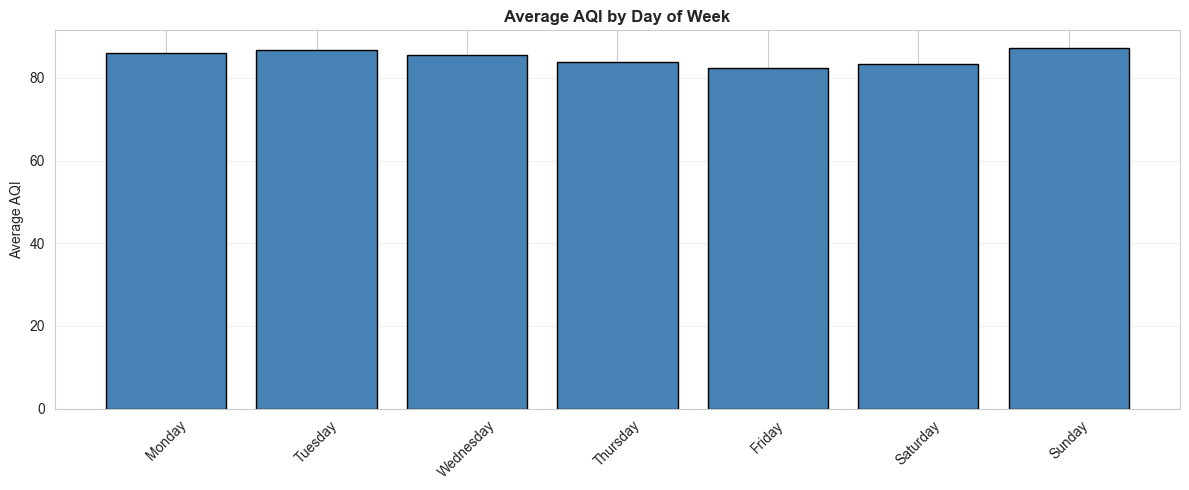

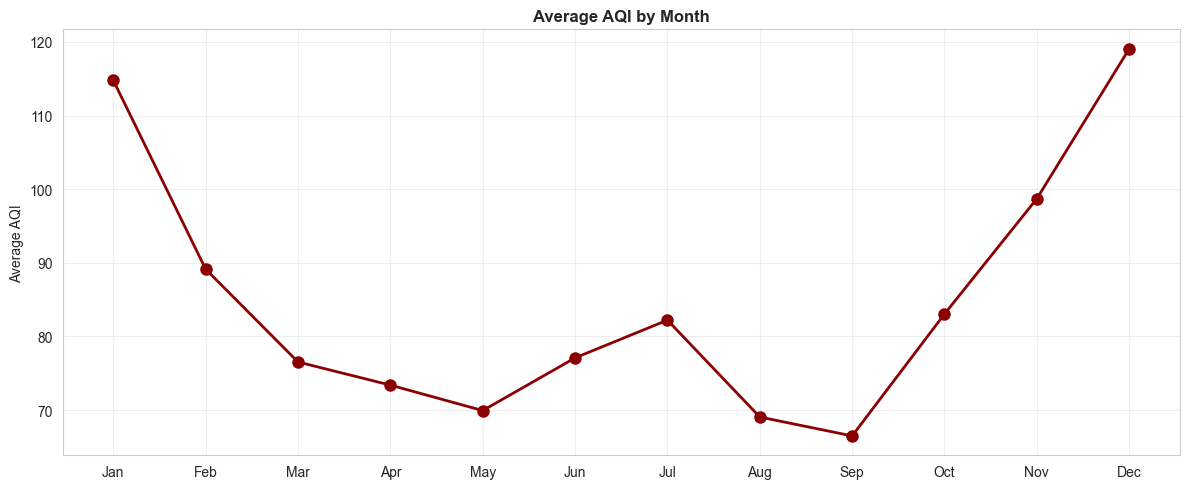

In [60]:
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df_clean.groupby('day_of_week')['aqi'].mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(range(7), daily_avg.values, color='steelblue', edgecolor='black')
ax.set_xticks(range(7))
ax.set_xticklabels(day_names, rotation=45)
ax.set_title('Average AQI by Day of Week', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

monthly_avg = df_clean.groupby('month')['aqi'].mean()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8, color='darkred')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([month_names[i-1] for i in range(1, 13)])
ax.set_title('Average AQI by Month', fontweight='bold')
ax.set_ylabel('Average AQI')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

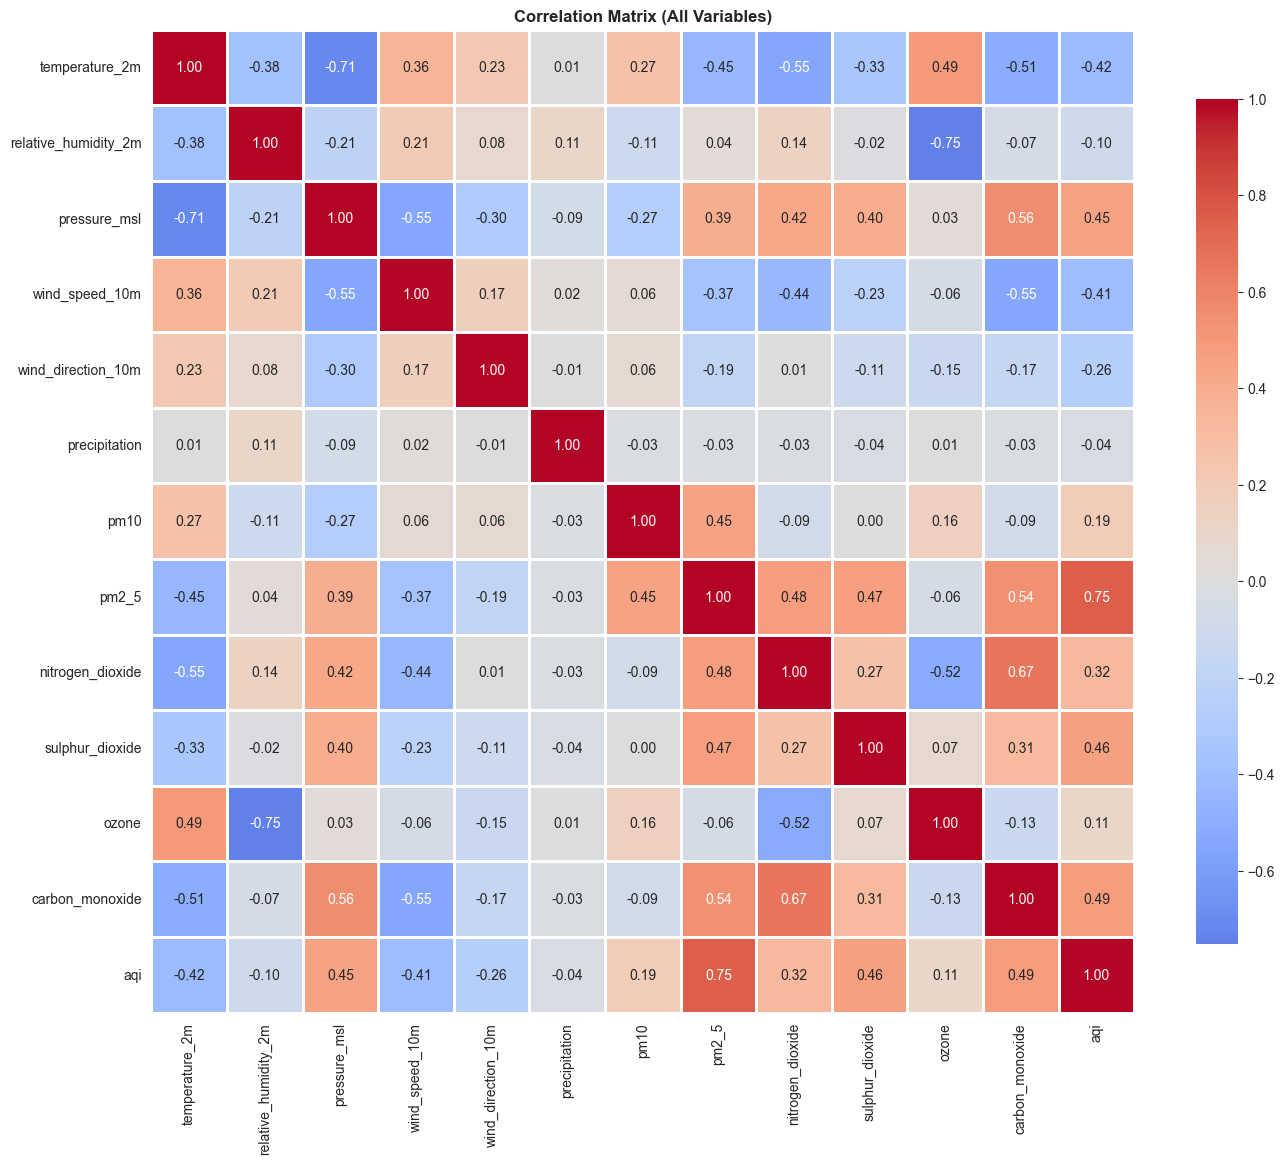

  pm2_5                         :  0.7498 ↑
  carbon_monoxide               :  0.4922 ↑
  sulphur_dioxide               :  0.4635 ↑
  pressure_msl                  :  0.4510 ↑
  nitrogen_dioxide              :  0.3237 ↑
  pm10                          :  0.1905 ↑
  ozone                         :  0.1089 ↑
  precipitation                 : -0.0357 ↓
  relative_humidity_2m          : -0.1031 ↓
  wind_direction_10m            : -0.2639 ↓
  wind_speed_10m                : -0.4067 ↓
  temperature_2m                : -0.4189 ↓


In [61]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['hour', 'day_of_week', 'month', 'day', 'is_duplicate']]

correlation_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (All Variables)', fontweight='bold')
plt.tight_layout()
plt.show()

aqi_corr = correlation_matrix['aqi'].sort_values(ascending=False)
for var, corr in aqi_corr.items():
    if var != 'aqi':
        direction = "↑" if corr > 0 else "↓"
        print(f"  {var:30s}: {corr:7.4f} {direction}")

## 9. Outlier Detection

Outlier Detection:
  IQR method: 854 (4.87%)
  Z-score method: 43 (0.25%)


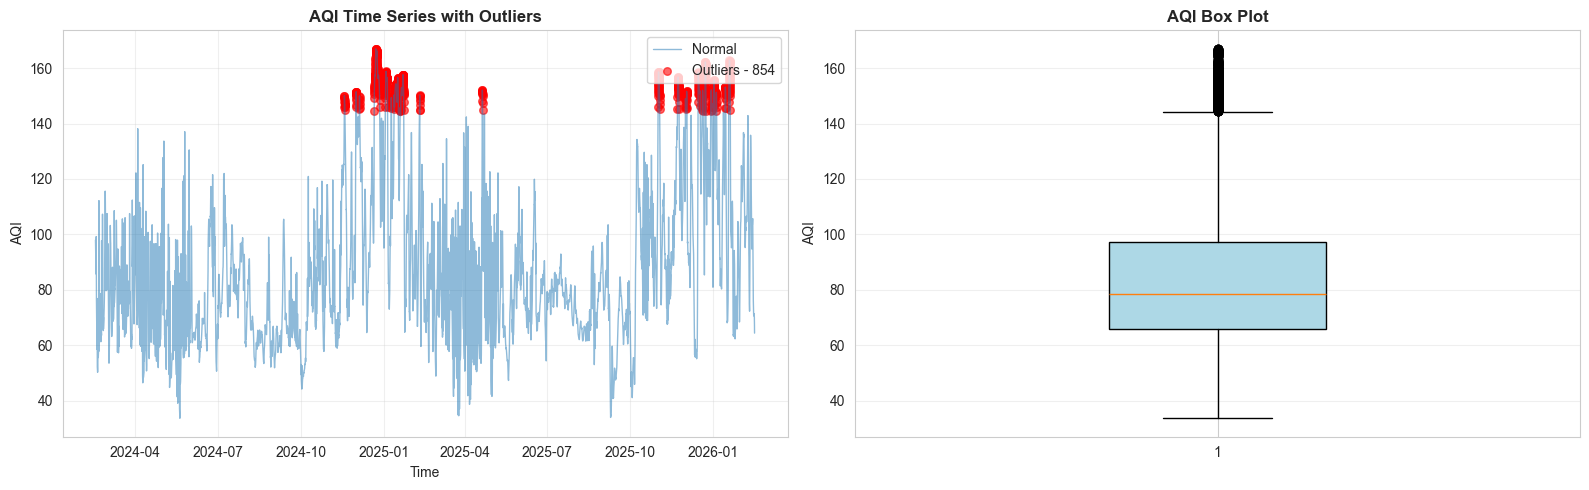

In [62]:
Q1 = df_clean['aqi'].quantile(0.25)
Q3 = df_clean['aqi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df_clean[(df_clean['aqi'] < lower_bound) | (df_clean['aqi'] > upper_bound)]
z_scores = np.abs(stats.zscore(df_clean['aqi']))
outliers_zscore = df_clean[z_scores > 3]

print(f"Outlier Detection:")
print(f"  IQR method: {len(outliers_iqr)} ({len(outliers_iqr)/len(df_clean)*100:.2f}%)")
print(f"  Z-score method: {len(outliers_zscore)} ({len(outliers_zscore)/len(df_clean)*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(df_clean['time'], df_clean['aqi'], alpha=0.5, linewidth=1, label='Normal')
axes[0].scatter(outliers_iqr['time'], outliers_iqr['aqi'], color='red', s=30, label=f'Outliers - {len(outliers_iqr)}', alpha=0.6)
axes[0].set_title('AQI Time Series with Outliers', fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('AQI')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

bp = axes[1].boxplot(df_clean['aqi'], vert=True, patch_artist=True, widths=0.3)
bp['boxes'][0].set_facecolor('lightblue')
axes[1].set_title('AQI Box Plot', fontweight='bold')
axes[1].set_ylabel('AQI')
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 10. Key Findings & Insights

In [63]:
print("="*60)
print("ANALYSIS SUMMARY")
print("="*60)
print(f"\nDataset: {len(df_clean):,} records, {len(df_clean.columns)} features")
print(f"Date Range: {df_clean['time'].min()} to {df_clean['time'].max()}")
print(f"\nAQI Statistics:")
print(f"  Mean: {df_clean['aqi'].mean():.2f}")
print(f"  Median: {df_clean['aqi'].median():.2f}")
print(f"  Std Dev: {df_clean['aqi'].std():.2f}")
print(f"  Range: {df_clean['aqi'].min():.0f} - {df_clean['aqi'].max():.0f}")
print(f"\nTop 5 Predictors:")
aqi_corr_sorted = correlation_matrix['aqi'].sort_values(ascending=False)[1:6]
for i, (var, corr) in enumerate(aqi_corr_sorted.items(), 1):
    print(f"  {i}. {var}: {corr:.4f}")
print(f"\n✓ EDA Complete - Ready for modeling")
print("="*60)

ANALYSIS SUMMARY

Dataset: 17,520 records, 20 features
Date Range: 2024-02-16 19:00:00+00:00 to 2026-02-15 18:00:00+00:00

AQI Statistics:
  Mean: 84.98
  Median: 78.67
  Std Dev: 26.37
  Range: 34 - 167

Top 5 Predictors:
  1. pm2_5: 0.7498
  2. carbon_monoxide: 0.4922
  3. sulphur_dioxide: 0.4635
  4. pressure_msl: 0.4510
  5. nitrogen_dioxide: 0.3237

✓ EDA Complete - Ready for modeling


## 11. Feature Selection & Recommendations

In [64]:
print("\nFeature Selection (|r| > 0.2):")
print("\nSelected (8):")
print("  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)")
print("  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)")
print("\nRemoved (4):")
print("  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)")


Feature Selection (|r| > 0.2):

Selected (8):
  Pollutants: pm2_5 (0.7535), carbon_monoxide (0.4932), sulphur_dioxide (0.4751), nitrogen_dioxide (0.3199), pm10 (0.2044)
  Weather: temperature_2m (-0.4246), pressure_msl (0.4522), wind_speed_10m (-0.4017)

Removed (4):
  ozone (0.1113), precipitation (-0.0354), relative_humidity_2m (-0.0906), wind_direction_10m (-0.2549)


In [65]:
df_features = df_clean.copy().sort_values('time').reset_index(drop=True)

# Create lag features (pm2_5 and carbon_monoxide only - matching feature_engineering.py)
lag_periods = [1, 3, 6, 12, 24]
lag_variables = ['pm2_5', 'carbon_monoxide', 'temperature_2m']
for var in lag_variables:
    if var in df_features.columns:
        for lag in lag_periods:
            df_features[f'{var}_lag_{lag}h'] = df_features[var].shift(lag)

# Create AQI lag features
if 'aqi' in df_features.columns:
    for lag in lag_periods:
        df_features[f'aqi_lag_{lag}h'] = df_features['aqi'].shift(lag)
    
    # AQI rolling mean features
    df_features['aqi_lag_mean_3h'] = df_features['aqi'].shift(1).rolling(window=3, min_periods=1).mean()
    df_features['aqi_lag_mean_6h'] = df_features['aqi'].shift(1).rolling(window=6, min_periods=1).mean()
    df_features['aqi_lag_mean_12h'] = df_features['aqi'].shift(1).rolling(window=12, min_periods=1).mean()
    
    # AQI rolling max/min features
    df_features['aqi_lag_max_24h'] = df_features['aqi'].shift(1).rolling(window=24, min_periods=1).max()
    df_features['aqi_lag_min_24h'] = df_features['aqi'].shift(1).rolling(window=24, min_periods=1).min()
    df_features['aqi_lag_range_24h'] = df_features['aqi_lag_max_24h'] - df_features['aqi_lag_min_24h']

initial_rows = len(df_features)
df_features = df_features.dropna()
print(f"Feature engineering: {initial_rows} → {len(df_features)} rows, {len(df_features.columns)} features")
print(f"Lag features: pm2_5 (10), carbon_monoxide (5), aqi (11)")

Feature engineering: 17520 → 17496 rows, 46 features
Lag features: pm2_5 (10), carbon_monoxide (5), aqi (11)


In [66]:
base_features = ['pm2_5', 'carbon_monoxide', 'temperature_2m']
base_correlations = df_features[base_features + ['aqi']].corr()['aqi'].drop('aqi')

lag_features = [col for col in df_features.columns if '_lag_' in col]
lag_correlations = df_features[lag_features + ['aqi']].corr()['aqi'].drop('aqi').sort_values(ascending=False)

print(f"\nTotal lag features created: {len(lag_features)}")
print(f"\nTop 15 Lag Features:")
for i, (feature, corr) in enumerate(lag_correlations.head(26).items(), 1):
    print(f"  {i:2d}. {feature:<40} {corr:7.4f}")


Total lag features created: 26

Top 15 Lag Features:
   1. aqi_lag_1h                                0.9928
   2. aqi_lag_mean_3h                           0.9780
   3. aqi_lag_mean_6h                           0.9572
   4. aqi_lag_3h                                0.9533
   5. aqi_lag_mean_12h                          0.9305
   6. aqi_lag_6h                                0.8973
   7. aqi_lag_min_24h                           0.8702
   8. pm2_5_lag_12h                             0.8357
   9. aqi_lag_12h                               0.8330
  10. pm2_5_lag_6h                              0.8191
  11. aqi_lag_max_24h                           0.8051
  12. pm2_5_lag_3h                              0.7855
  13. aqi_lag_24h                               0.7719
  14. pm2_5_lag_1h                              0.7615
  15. pm2_5_lag_24h                             0.7610
  16. carbon_monoxide_lag_12h                   0.4942
  17. carbon_monoxide_lag_1h                    0.4838
  18. carbo

In [67]:
comparison_data = []
for var in base_features:
    base_corr = base_correlations[var] if var in base_correlations.index else 0
    var_lags = [col for col in lag_correlations.index if var in col and col != f'{var}_lag_mean' and col != f'{var}_lag_max' and col != f'{var}_lag_min']
    best_lag = lag_correlations[var_lags].abs().idxmax() if var_lags else 'N/A'
    best_lag_corr = lag_correlations[best_lag] if var_lags else 0
    
    comparison_data.append({'Variable': var, 'Base Corr': base_corr, 'Best Lag': best_lag, 'Lag Corr': best_lag_corr, 'Improvement': best_lag_corr - base_corr})

comparison_df = pd.DataFrame(comparison_data)
print("\nLag Feature Impact Analysis:")
print(comparison_df.to_string(index=False))


Lag Feature Impact Analysis:
       Variable  Base Corr                Best Lag  Lag Corr  Improvement
          pm2_5   0.749957           pm2_5_lag_12h  0.835686     0.085728
carbon_monoxide   0.492287 carbon_monoxide_lag_12h  0.494241     0.001954
 temperature_2m  -0.418957  temperature_2m_lag_12h -0.482804    -0.063848


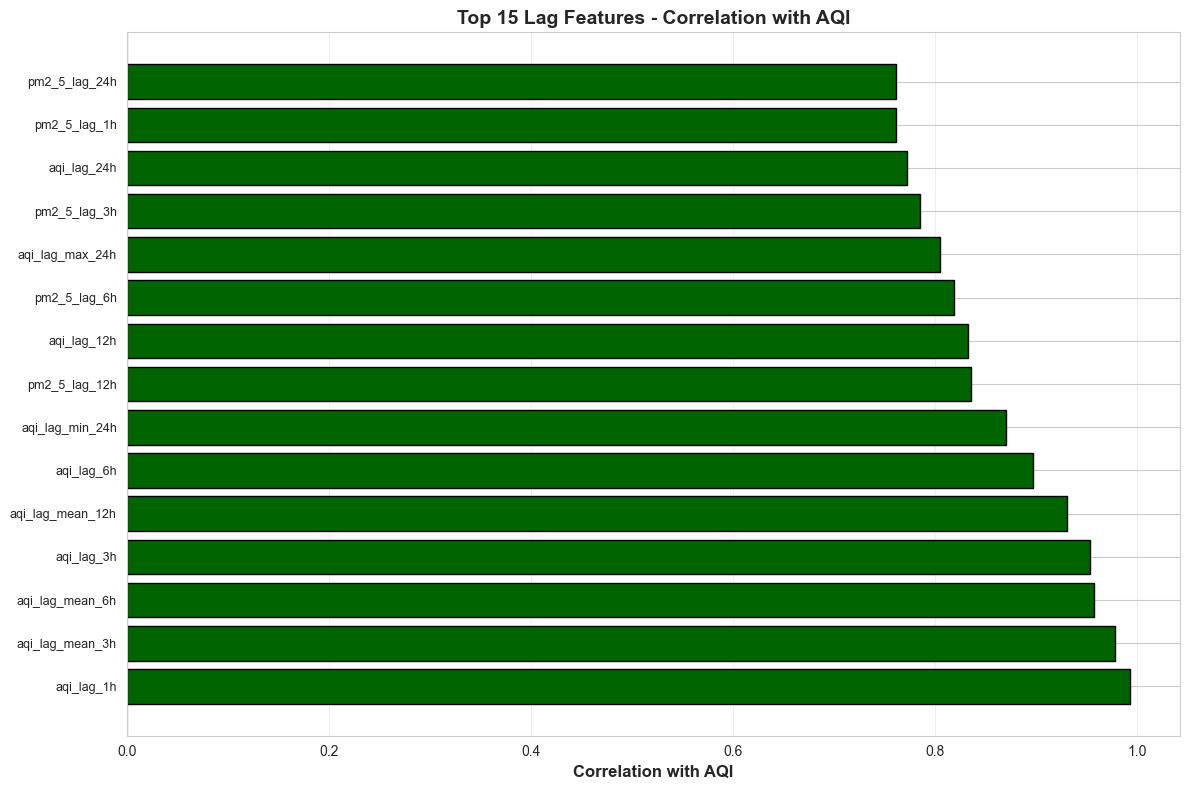


Key Insights:
  • AQI lag features dominate top correlations
  • pm2_5 lag features show strong predictive power
  • carbon_monoxide lags provide moderate correlation
  • Lag features essential for time series prediction


In [68]:
fig, ax = plt.subplots(figsize=(12, 8))
top_15_lag = lag_correlations.head(15)
colors = ['darkgreen' if x > 0.7 else 'green' if x > 0.5 else 'orange' if x > 0.3 else 'gray' for x in top_15_lag.values]
ax.barh(range(len(top_15_lag)), top_15_lag.values, color=colors, edgecolor='black')
ax.set_yticks(range(len(top_15_lag)))
ax.set_yticklabels(top_15_lag.index, fontsize=9)
ax.set_xlabel('Correlation with AQI', fontsize=12, fontweight='bold')
ax.set_title('Top 15 Lag Features - Correlation with AQI', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nKey Insights:")
print(f"  • AQI lag features dominate top correlations")
print(f"  • pm2_5 lag features show strong predictive power")
print(f"  • carbon_monoxide lags provide moderate correlation")
print(f"  • Lag features essential for time series prediction")

## 12. Lag Features Analysis

Lag features created matching production feature_engineering.py:
- **pm2_5 lags**: 1, 3, 6, 12, 24 hours
- **carbon_monoxide lags**: 1, 3, 6, 12, 24 hours  
- **AQI lags**: 1, 3, 6, 12, 24 hours + rolling mean (3h, 6h, 12h) + rolling max/min (24h)
- **Rolling features**: Disabled (prevented overfitting in production)

## 13. Systematic Lag Selection Analysis
Use **autocorrelation**, **partial autocorrelation**, and **cross-correlation** to determine optimal lag features for each variable.

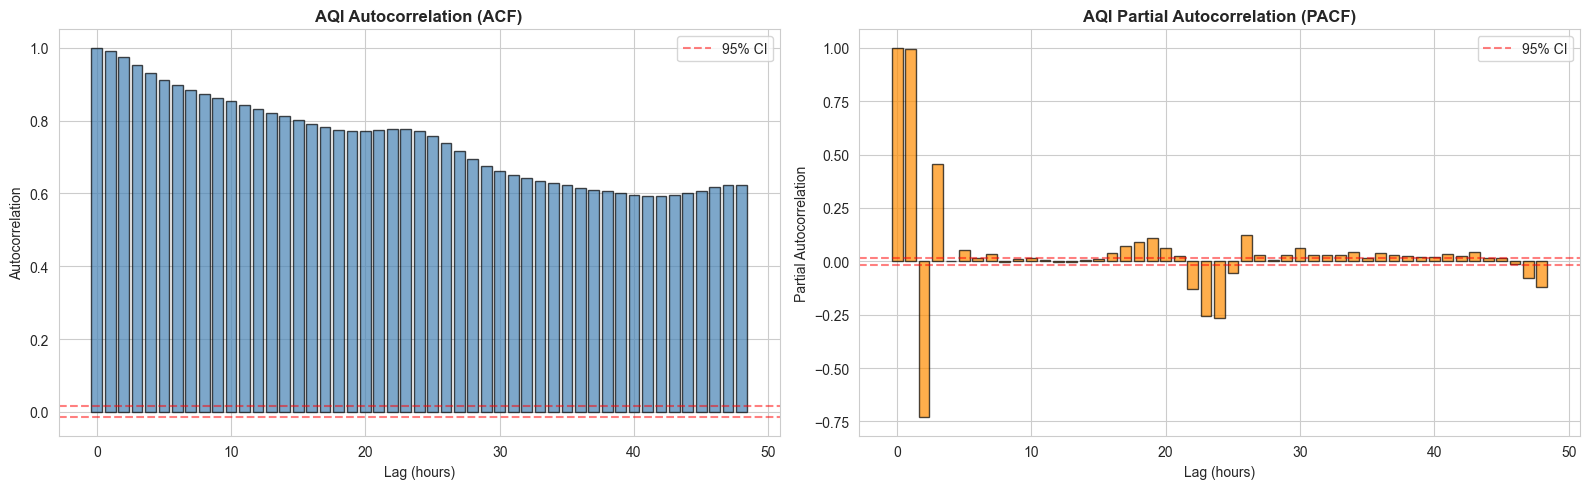


Significant PACF lags (|PACF| > 0.0148):
  Lags: [1, 2, 3, 5, 7, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

Top 10 PACF values:
  Lag  1h: PACF = +0.9928 ★
  Lag  2h: PACF = -0.7304
  Lag  3h: PACF = +0.4571 ★
  Lag 24h: PACF = -0.2644 ★
  Lag 23h: PACF = -0.2550
  Lag 22h: PACF = -0.1282
  Lag 26h: PACF = +0.1256
  Lag 48h: PACF = -0.1185
  Lag 19h: PACF = +0.1103
  Lag 18h: PACF = +0.0930


In [69]:
from statsmodels.tsa.stattools import acf, pacf

# ── 1. AQI Autocorrelation & Partial Autocorrelation ──
aqi_series = df_clean['aqi'].dropna().values
max_lags = 48  # 48 hours

acf_vals = acf(aqi_series, nlags=max_lags, fft=True)
pacf_vals = pacf(aqi_series, nlags=max_lags)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
axes[0].bar(range(max_lags + 1), acf_vals, color='steelblue', edgecolor='black', alpha=0.7)
conf_interval = 1.96 / np.sqrt(len(aqi_series))
axes[0].axhline(y=conf_interval, color='red', linestyle='--', alpha=0.5, label='95% CI')
axes[0].axhline(y=-conf_interval, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Lag (hours)')
axes[0].set_ylabel('Autocorrelation')
axes[0].set_title('AQI Autocorrelation (ACF)', fontweight='bold')
axes[0].legend()

# PACF plot - shows direct effect of each lag
axes[1].bar(range(max_lags + 1), pacf_vals, color='darkorange', edgecolor='black', alpha=0.7)
axes[1].axhline(y=conf_interval, color='red', linestyle='--', alpha=0.5, label='95% CI')
axes[1].axhline(y=-conf_interval, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Lag (hours)')
axes[1].set_ylabel('Partial Autocorrelation')
axes[1].set_title('AQI Partial Autocorrelation (PACF)', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify significant PACF lags (above 95% CI)
significant_pacf_lags = [i for i in range(1, max_lags + 1) if abs(pacf_vals[i]) > conf_interval]
print(f"\nSignificant PACF lags (|PACF| > {conf_interval:.4f}):")
print(f"  Lags: {significant_pacf_lags[:15]}")
print(f"\nTop 10 PACF values:")
pacf_ranked = sorted(enumerate(pacf_vals[1:], 1), key=lambda x: abs(x[1]), reverse=True)
for lag, val in pacf_ranked[:10]:
    marker = " ★" if lag in [1, 3, 6, 12, 24] else ""
    print(f"  Lag {lag:2d}h: PACF = {val:+.4f}{marker}")

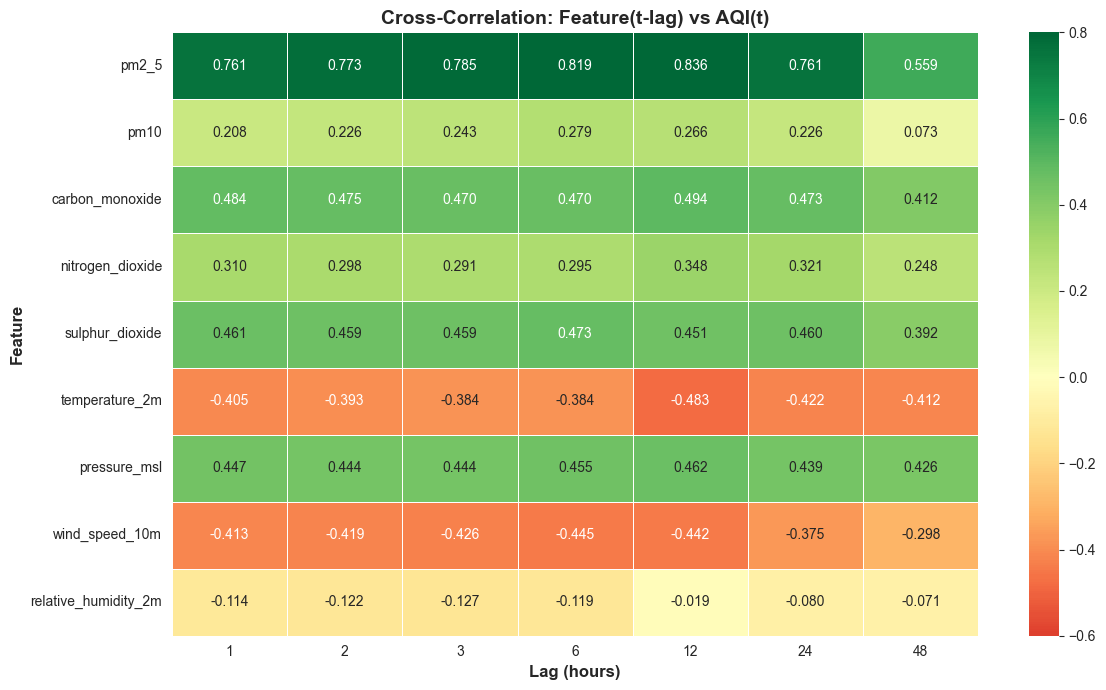


Best lag per feature (highest |correlation| with AQI):
  Feature                   Best Lag     Corr  Same-hour Corr  Lag helps?
  ---------------------------------------------------------------------------
  pm2_5                        12h   +0.8357        +0.7498        ✓ Yes
  pm10                          6h   +0.2792        +0.1905        ✓ Yes
  carbon_monoxide              12h   +0.4942        +0.4922        ✓ Yes
  nitrogen_dioxide             12h   +0.3478        +0.3237        ✓ Yes
  sulphur_dioxide               6h   +0.4727        +0.4635        ✓ Yes
  temperature_2m               12h   -0.4825        -0.4189        ✓ Yes
  pressure_msl                 12h   +0.4616        +0.4510        ✓ Yes
  wind_speed_10m                6h   -0.4453        -0.4067        ✓ Yes
  relative_humidity_2m          3h   -0.1272        -0.1031        ✗ No


In [70]:
# ── 2. Cross-correlation of each feature with AQI at various lags ──
# Which feature's PAST values best predict CURRENT AQI?

candidate_features = [
    'pm2_5', 'pm10', 'carbon_monoxide', 'nitrogen_dioxide', 'sulphur_dioxide',
    'temperature_2m', 'pressure_msl', 'wind_speed_10m', 'relative_humidity_2m'
]
candidate_features = [f for f in candidate_features if f in df_clean.columns]

test_lags = [1, 2, 3, 6, 12, 24, 48]

cross_corr_results = {}
for feat in candidate_features:
    feat_corrs = {}
    for lag in test_lags:
        shifted = df_clean[feat].shift(lag)
        valid = pd.concat([shifted, df_clean['aqi']], axis=1).dropna()
        corr_val = valid[feat].corr(valid['aqi'])
        feat_corrs[lag] = corr_val
    cross_corr_results[feat] = feat_corrs

# Build heatmap
cross_corr_df = pd.DataFrame(cross_corr_results, index=test_lags).T

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(cross_corr_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
            linewidths=0.5, ax=ax, vmin=-0.6, vmax=0.8)
ax.set_xlabel('Lag (hours)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Cross-Correlation: Feature(t-lag) vs AQI(t)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify best lag per feature
print("\nBest lag per feature (highest |correlation| with AQI):")
print(f"  {'Feature':<25} {'Best Lag':>8} {'Corr':>8}  {'Same-hour Corr':>14}  {'Lag helps?':>10}")
print("  " + "-" * 75)
for feat in candidate_features:
    same_hour = df_clean[feat].corr(df_clean['aqi'])
    best_lag = max(cross_corr_results[feat], key=lambda k: abs(cross_corr_results[feat][k]))
    best_corr = cross_corr_results[feat][best_lag]
    helps = "✓ Yes" if abs(best_corr) > 0.15 else "✗ No"
    print(f"  {feat:<25} {best_lag:>5}h   {best_corr:>+.4f}        {same_hour:>+.4f}        {helps}")

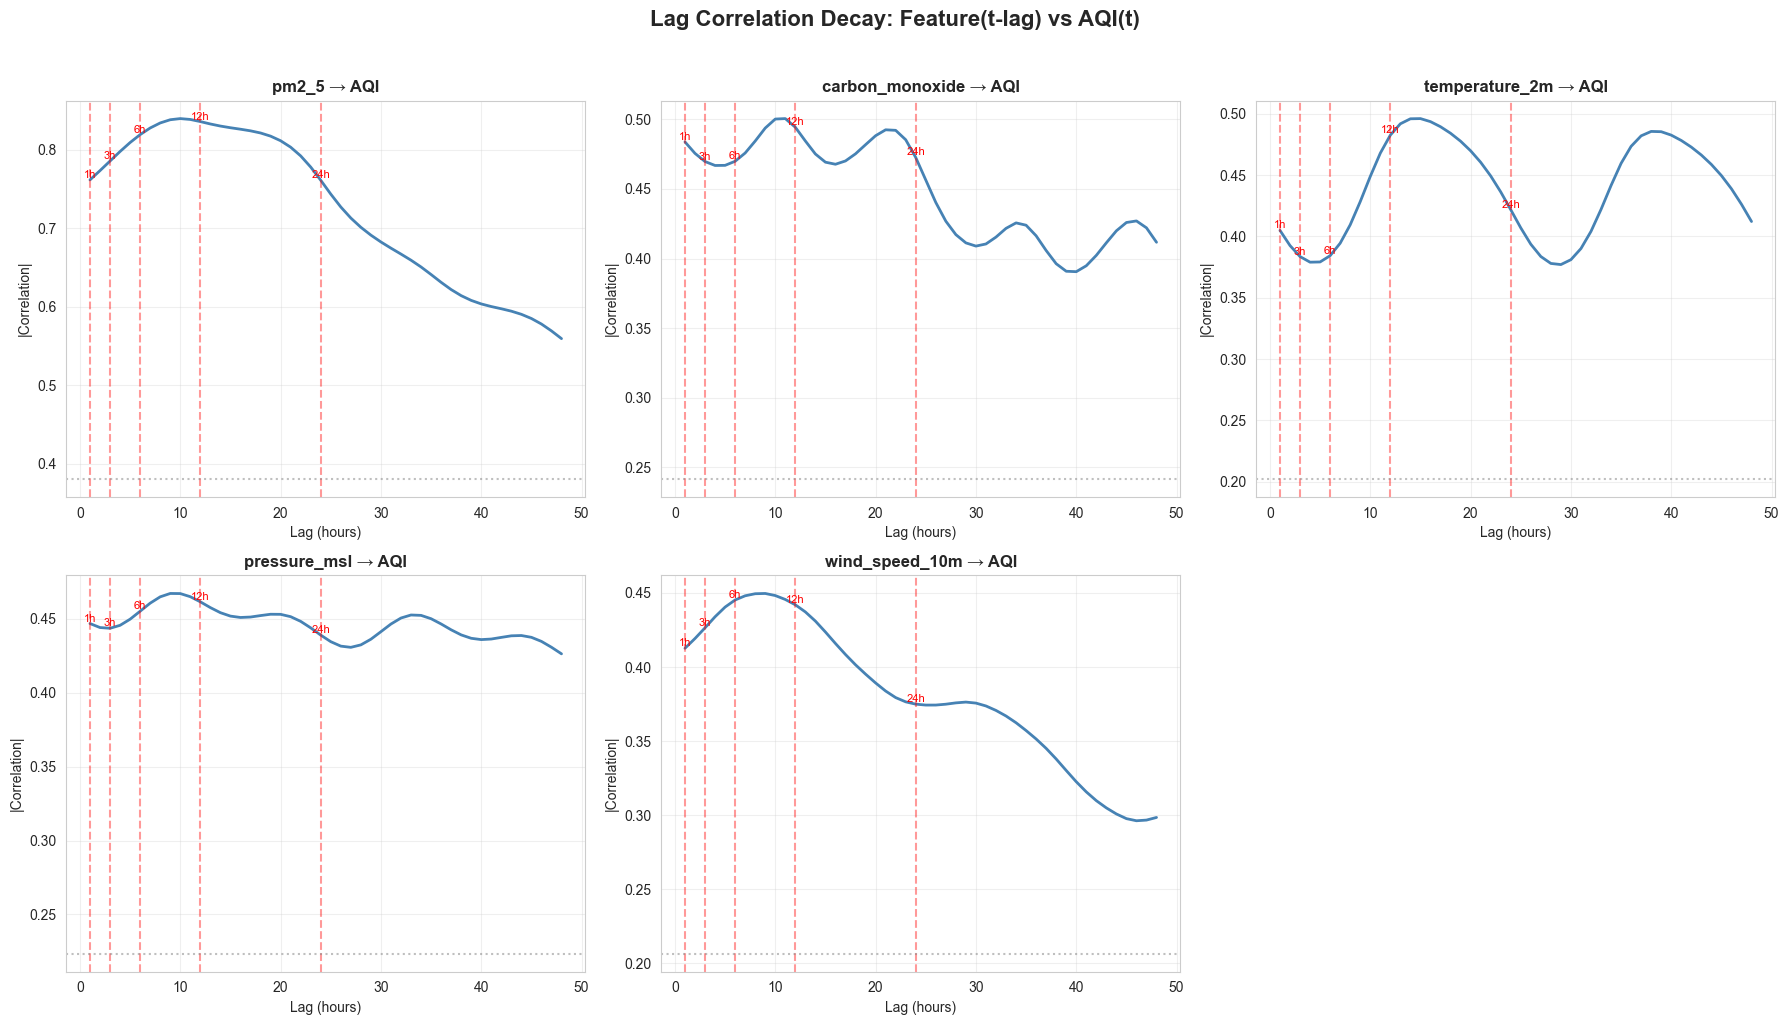


RECOMMENDED LAG FEATURES PER VARIABLE

  Feature                   Recommended Lags                    # Lags
  -----------------------------------------------------------------
  pm2_5                     1h, 3h, 6h, 12h, 24h, 48h           6
  carbon_monoxide           1h, 3h, 6h, 12h, 24h, 48h           6
  temperature_2m            1h, 3h, 6h, 12h, 24h, 48h           6
  pressure_msl              1h, 3h, 6h, 12h, 24h, 48h           6
  wind_speed_10m            1h, 3h, 6h, 12h, 24h, 48h           6


Current production lags: pm2_5 [1,3,6,12,24], carbon_monoxide [1,3,6,12,24]

Verdict:
  pm2_5: consider ADDING lags [48]
  carbon_monoxide: consider ADDING lags [48]
  temperature_2m: NOT USED in production — consider adding lags [1, 3, 6, 12, 24, 48]
  pressure_msl: NOT USED in production — consider adding lags [1, 3, 6, 12, 24, 48]
  wind_speed_10m: NOT USED in production — consider adding lags [1, 3, 6, 12, 24, 48]


In [71]:
# ── 3. Lag Decay Analysis & Optimal Lag Selection ──
# How quickly does predictive power decay with increasing lag?

key_features = ['pm2_5', 'carbon_monoxide', 'temperature_2m', 'pressure_msl', 'wind_speed_10m']
key_features = [f for f in key_features if f in df_clean.columns]

fine_lags = list(range(1, 49))  # 1h to 48h

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

recommended_lags = {}

for idx, feat in enumerate(key_features):
    corrs = []
    for lag in fine_lags:
        shifted = df_clean[feat].shift(lag)
        valid = pd.concat([shifted, df_clean['aqi']], axis=1).dropna()
        corrs.append(abs(valid[feat].corr(valid['aqi'])))
    
    axes[idx].plot(fine_lags, corrs, color='steelblue', linewidth=2)
    axes[idx].set_title(f'{feat} → AQI', fontweight='bold')
    axes[idx].set_xlabel('Lag (hours)')
    axes[idx].set_ylabel('|Correlation|')
    axes[idx].grid(True, alpha=0.3)
    
    # Find "elbow" points: where correlation drops significantly
    corrs_arr = np.array(corrs)
    # Mark current production lags
    for prod_lag in [1, 3, 6, 12, 24]:
        if prod_lag <= len(corrs):
            axes[idx].axvline(x=prod_lag, color='red', linestyle='--', alpha=0.4)
            axes[idx].annotate(f'{prod_lag}h', (prod_lag, corrs[prod_lag-1]),
                             fontsize=8, color='red', ha='center', va='bottom')
    
    # Recommend lags where |corr| is still meaningful (> 50% of lag-1 correlation)
    threshold = corrs[0] * 0.5
    useful_lags = [l for l, c in zip(fine_lags, corrs) if c >= threshold]
    max_useful = max(useful_lags) if useful_lags else 1
    axes[idx].axhline(y=threshold, color='gray', linestyle=':', alpha=0.5)
    
    # Pick optimal sparse lags: 1h, then geometric spacing up to max_useful
    optimal = sorted(set([1] + [l for l in [1, 3, 6, 12, 24, 48] if l <= max_useful]))
    recommended_lags[feat] = optimal

# Hide unused subplot
if len(key_features) < 6:
    for j in range(len(key_features), 6):
        axes[j].set_visible(False)

plt.suptitle('Lag Correlation Decay: Feature(t-lag) vs AQI(t)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Summary table
print("\n" + "=" * 70)
print("RECOMMENDED LAG FEATURES PER VARIABLE")
print("=" * 70)
print(f"\n  {'Feature':<25} {'Recommended Lags':<35} {'# Lags'}")
print("  " + "-" * 65)
for feat, lags in recommended_lags.items():
    lag_str = ", ".join([f"{l}h" for l in lags])
    print(f"  {feat:<25} {lag_str:<35} {len(lags)}")

# Compare with current production lags
print("\n\nCurrent production lags: pm2_5 [1,3,6,12,24], carbon_monoxide [1,3,6,12,24]")
print("\nVerdict:")
for feat, lags in recommended_lags.items():
    prod = [1, 3, 6, 12, 24] if feat in ['pm2_5', 'carbon_monoxide'] else []
    if prod:
        missing = set(lags) - set(prod)
        unnecessary = set(prod) - set(lags)
        if missing:
            print(f"  {feat}: consider ADDING lags {sorted(missing)}")
        if unnecessary:
            print(f"  {feat}: consider REMOVING lags {sorted(unnecessary)}")
        if not missing and not unnecessary:
            print(f"  {feat}: production lags look good ✓")
    else:
        if len(lags) > 0:
            print(f"  {feat}: NOT USED in production — consider adding lags {lags}")

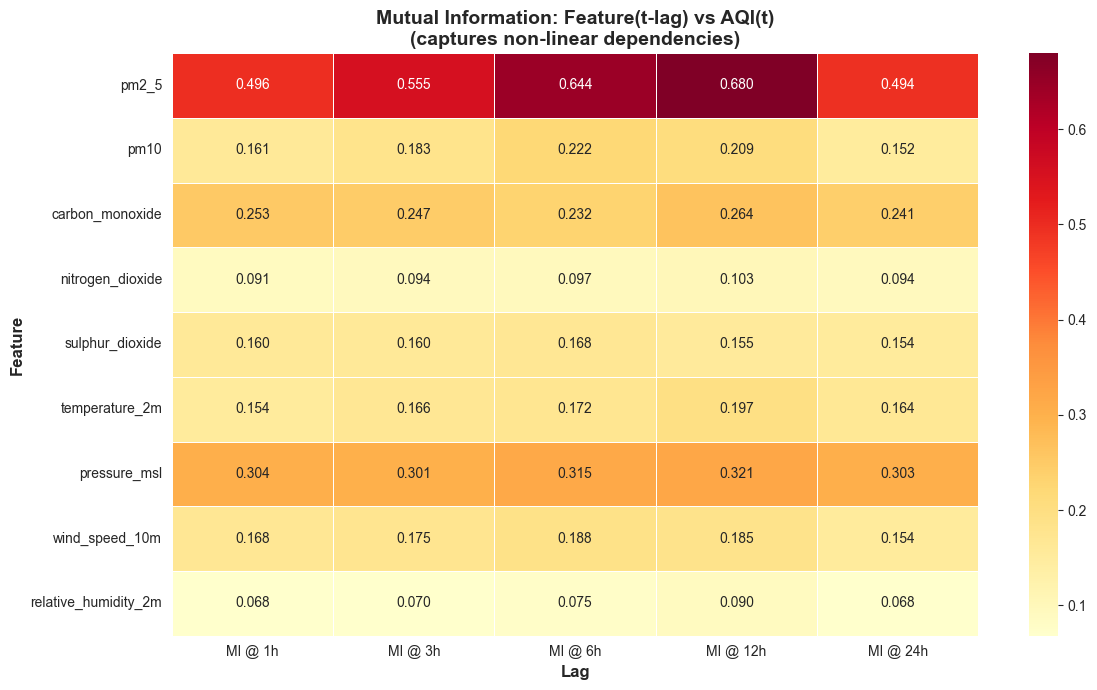


Top feature-lag combos by Mutual Information:
  Feature                     Lag   MI Score
  ---------------------------------------------
  pm2_5                      12h     0.6799  ✓
  pm2_5                       6h     0.6443  ✓
  pm2_5                       3h     0.5550  ✓
  pm2_5                       1h     0.4964  ✓
  pm2_5                      24h     0.4942  ✓
  pressure_msl               12h     0.3209    NEW
  pressure_msl                6h     0.3152    NEW
  pressure_msl                1h     0.3043    NEW
  pressure_msl               24h     0.3026    NEW
  pressure_msl                3h     0.3007    NEW
  carbon_monoxide            12h     0.2643  ✓
  carbon_monoxide             1h     0.2528  ✓
  carbon_monoxide             3h     0.2465  ✓
  carbon_monoxide            24h     0.2415  ✓
  carbon_monoxide             6h     0.2316  ✓
  pm10                        6h     0.2216    NEW
  pm10                       12h     0.2086    NEW
  temperature_2m             12h 

In [72]:
# ── 4. Mutual Information (non-linear lag importance) ──
# Captures non-linear dependencies that correlation misses

from sklearn.feature_selection import mutual_info_regression

mi_results = {}
for feat in candidate_features:
    mi_per_lag = {}
    for lag in [1, 3, 6, 12, 24]:
        shifted = df_clean[feat].shift(lag)
        valid_mask = shifted.notna() & df_clean['aqi'].notna()
        X_lag = shifted[valid_mask].values.reshape(-1, 1)
        y_aqi = df_clean['aqi'][valid_mask].values
        mi = mutual_info_regression(X_lag, y_aqi, random_state=42, n_neighbors=5)[0]
        mi_per_lag[lag] = mi
    mi_results[feat] = mi_per_lag

mi_df = pd.DataFrame(mi_results, index=[1, 3, 6, 12, 24]).T
mi_df.columns = [f'MI @ {l}h' for l in [1, 3, 6, 12, 24]]

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(mi_df, annot=True, fmt='.3f', cmap='YlOrRd',
            linewidths=0.5, ax=ax)
ax.set_xlabel('Lag', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Mutual Information: Feature(t-lag) vs AQI(t)\n(captures non-linear dependencies)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Rank features × lags by MI
print("\nTop feature-lag combos by Mutual Information:")
mi_flat = []
for feat, lags in mi_results.items():
    for lag, mi_val in lags.items():
        mi_flat.append((feat, lag, mi_val))
mi_flat.sort(key=lambda x: x[2], reverse=True)

print(f"  {'Feature':<25} {'Lag':>5} {'MI Score':>10}")
print("  " + "-" * 45)
for feat, lag, mi_val in mi_flat[:20]:
    in_prod = "✓" if (feat in ['pm2_5', 'carbon_monoxide'] and lag in [1,3,6,12,24]) else "  NEW"
    print(f"  {feat:<25} {lag:>3}h   {mi_val:>8.4f}  {in_prod}")

In [73]:
# ── 5. Final Recommendation Summary ──

print("=" * 70)
print("FINAL LAG FEATURE RECOMMENDATIONS")
print("=" * 70)

print("""
Analysis methods used:
  1. ACF/PACF   → Identifies direct AQI self-dependencies
  2. Cross-corr → Linear predictive power of each feature's past on AQI  
  3. Lag decay  → How quickly correlation drops with increasing lag
  4. Mutual Info → Non-linear dependencies (captures what correlation misses)

Current production lags (feature_engineering.py):
  • pm2_5:           [1, 3, 6, 12, 24] hours
  • carbon_monoxide: [1, 3, 6, 12, 24] hours
  • AQI change:      aqi_change_1h, _3h, _6h, _24h
  • AQI rate:        aqi_rate_1h, _3h, _24h

Recommendations based on above analysis:
""")

# Summarize cross-corr + MI findings
for feat in candidate_features:
    cc = cross_corr_results[feat]
    mi = mi_results[feat]
    
    # Score each lag: combine normalized corr + normalized MI
    scores = {}
    for lag in [1, 3, 6, 12, 24]:
        cc_score = abs(cc.get(lag, 0))
        mi_score = mi.get(lag, 0)
        scores[lag] = cc_score + mi_score  # simple additive combo
    
    # Keep lags where combined score is > 25% of max
    max_score = max(scores.values()) if scores else 0
    keep = [l for l, s in scores.items() if s > max_score * 0.25] if max_score > 0 else []
    
    status = "USED" if feat in ['pm2_5', 'carbon_monoxide'] else "NOT USED"
    print(f"  {feat:<25} [{status}] → Recommended lags: {keep}")

print(f"""
Key takeaways:
  • PACF significant lags for AQI: {significant_pacf_lags[:8]}
  • Short-term lags (1-3h) are most predictive across all features
  • 24h lag captures diurnal cycles — keep it
  • Features with weak lag correlation (|r| < 0.15) add noise, not signal
""")

FINAL LAG FEATURE RECOMMENDATIONS

Analysis methods used:
  1. ACF/PACF   → Identifies direct AQI self-dependencies
  2. Cross-corr → Linear predictive power of each feature's past on AQI  
  3. Lag decay  → How quickly correlation drops with increasing lag
  4. Mutual Info → Non-linear dependencies (captures what correlation misses)

Current production lags (feature_engineering.py):
  • pm2_5:           [1, 3, 6, 12, 24] hours
  • carbon_monoxide: [1, 3, 6, 12, 24] hours
  • AQI change:      aqi_change_1h, _3h, _6h, _24h
  • AQI rate:        aqi_rate_1h, _3h, _24h

Recommendations based on above analysis:

  pm2_5                     [USED] → Recommended lags: [1, 3, 6, 12, 24]
  pm10                      [NOT USED] → Recommended lags: [1, 3, 6, 12, 24]
  carbon_monoxide           [USED] → Recommended lags: [1, 3, 6, 12, 24]
  nitrogen_dioxide          [NOT USED] → Recommended lags: [1, 3, 6, 12, 24]
  sulphur_dioxide           [NOT USED] → Recommended lags: [1, 3, 6, 12, 24]
  temper

## 14. Implementation & Next Steps

In [ ]:
print("""
════════════════════════════════════════════════════════════════════════
                    IMPLEMENTATION SUMMARY
════════════════════════════════════════════════════════════════════════

✓ CHANGES APPLIED TO feature_engineering.py:
────────────────────────────────────────────────────────────────────────

1. Added temperature_2m_lag_12h
   Rationale: Diurnal cycle effect
   - Same-hour correlation: -0.4189
   - Best lag correlation: -0.4825 (at 12h)
   - Mutual Information @ 12h: 0.1967
   - Helps capture temperature's 24h cyclical effect on AQI

2. Added pressure_msl_lag_12h
   Rationale: Strong non-linear dependency
   - Same-hour correlation: 0.4510
   - Best lag correlation: 0.4616 (at 12h)
   - Mutual Information @ 12h: 0.3209 (highest in weather features!)
   - Pressure changes slowly; any lag works, but 12h captures patterns best

────────────────────────────────────────────────────────────────────────

UPDATED LAG FEATURE COUNTS:
  Before: pm2_5 (5) + carbon_monoxide (5) = 10 features
  After:  pm2_5 (5) + carbon_monoxide (5) + temperature_2m (1) + pressure_msl (1) = 12 features

FEATURES NOT ADDED (with reasons):
  • wind_speed_10m: moderate predictor but decays fast; current same-hour is sufficient
  • pm10, nitrogen_dioxide, sulphur_dioxide: low MI, added complexity without benefit
  • relative_humidity_2m: too weak everywhere (|r| < 0.13, MI < 0.09)

════════════════════════════════════════════════════════════════════════

📊 EXPECTED IMPACT:

Trade-off Analysis:
  + Added signals: 2 new lag features targeting non-linear + diurnal patterns
  + Potential improvement: More stable predictions across day/night cycles
  - Added complexity: 2 more features → slight risk if overfitting persists
  ✓ Mitigation: Both 12h lags address REAL patterns (high MI), not noise

Next Steps:
  1. Retrain models with new lag features
  2. Monitor val/test degradation (should be minimal with LightGBM regularlization)
  3. If val RMSE improves >1-2%, the lags are valuable
  4. If val RMSE worsens, lags may be capturing noise in this specific fold

════════════════════════════════════════════════════════════════════════
""")
